In [1]:
# Install packages required

import sys
!{sys.executable} -m pip install --user pandas matplotlib PyQt5 keras tensorflow

In [17]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plotter
import PyQt5
from pandas import datetime
from numpy import array

from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

# keras & sklearn imports
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [3]:
# Fetch & structure data from CSV file
RawData = pd.read_csv('../Data/solarpower_cumuldaybyday.csv', header=None)
RawData.columns = ['Date', 'Reading', 'Extra']
RawData.drop(columns=['Extra'], inplace=True)
RawData.head(5)

,Date,Reading
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2
3,29/10/2011,29.6
4,30/10/2011,34.2


In [4]:
# Set the date as index
RawData.set_index('Date', inplace=True)
RawData.head(5)

,Reading
Date,
26/10/2011,0.1
27/10/2011,10.2
28/10/2011,20.2
29/10/2011,29.6
30/10/2011,34.2


In [5]:
# Reindex the data
Data = RawData.reindex(pd.date_range(start=datetime(2011, 10, 27), periods=2470, freq='d'))
Data.Reading = RawData.Reading.values
Data.head(5)

,Reading
2011-10-27,0.1
2011-10-28,10.2
2011-10-29,20.2
2011-10-30,29.6
2011-10-31,34.2


In [6]:
# Convert 'Reading' values to numeric type & 'Date' values to datetime type  
Data.Reading = pd.to_numeric(Data.Reading)
Data.index = pd.to_datetime(Data.index)
Data.head(5)

,Reading
2011-10-27,0.1
2011-10-28,10.2
2011-10-29,20.2
2011-10-30,29.6
2011-10-31,34.2


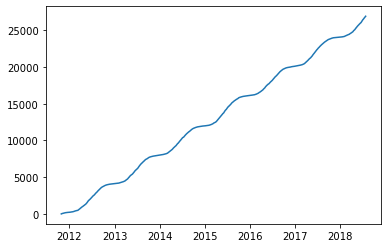

In [7]:
# Plot Data

# Uncomment the below line to open plots in a separate interactive window
# %matplotlib qt

# Uncomment the below line to open plots inline
%matplotlib inline
plotter.plot(Data)

In [8]:
# Using 60% of data for training, 40% for validation.

TRAIN_SIZE = 0.60
train_size = int(len(Data) * TRAIN_SIZE)
test_size = len(Data) - train_size
train, test = Data[0:train_size], Data[train_size:len(Data)]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1482, 988)


In [11]:
# Split Data into samples

def split_sequence(data, samples_length):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_seq = i + samples_length
        # check if we are beyond the sequence
        if end_seq > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_seq], data[end_seq]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


sample_length = 30
dataset = Data.Reading
Samples, Samples_Output = split_sequence(dataset, sample_length)

print('Samples Array: \n', Samples)
print('\nSamples Array Size (rows, columns): ', Samples.shape)
print('\n\nSamples Target Array: \n', Samples_Output)
print('\nSamples Target Array Size (rows, columns): ', Samples_Output.shape)

Samples Array: 
 [[1.0000e-01 1.0200e+01 2.0200e+01 ... 1.4500e+02 1.4830e+02 1.4980e+02]
 [1.0200e+01 2.0200e+01 2.9600e+01 ... 1.4830e+02 1.4980e+02 1.5170e+02]
 [2.0200e+01 2.9600e+01 3.4200e+01 ... 1.4980e+02 1.5170e+02 1.5240e+02]
 ...
 [2.6203e+04 2.6229e+04 2.6258e+04 ... 2.6816e+04 2.6841e+04 2.6861e+04]
 [2.6229e+04 2.6258e+04 2.6285e+04 ... 2.6841e+04 2.6861e+04 2.6879e+04]
 [2.6258e+04 2.6285e+04 2.6315e+04 ... 2.6861e+04 2.6879e+04 2.6906e+04]]

Samples Array Size (rows, columns):  (2440, 30)


Samples Target Array: 
 [  151.7   152.4   156.1 ... 26879.  26906.  26920. ]

Samples Target Array Size (rows, columns):  (2440,)


In [12]:
# Modify shape of data

number_of_features = 1
number_of_samples = Samples.shape[0]
Samples = Samples.reshape(number_of_samples, sample_length, number_of_features)
print(Samples.shape)

(2440, 30, 1)


In [13]:
# Creation of Vanilla LSTM Model that uses single hidden layer of LSTM units and an output layer to make a prediction

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sample_length, number_of_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
# Fit Model
model.fit(Samples, Samples_Output, epochs=200, verbose=0)

In [15]:
# check model accuracy
# Fit model on train data

Train, Train_Output = split_sequence(train.Reading, sample_length)
Test, Test_Output = split_sequence(test.Reading, sample_length)
Train = Train.reshape(Train.shape[0], Train.shape[1], number_of_features)
model.fit(Train, Train_Output, epochs=200, verbose=0)

In [18]:
# check model accuracy
# Predict test values

predicted = list()
i=0
for x in Test:
    x_input = x.reshape((1, 30, 1))
    yhat = model.predict(x_input, verbose=0)
    predicted = np.append(predicted, yhat)
    print('predicted=%f, expected=%f' % (yhat, Test_Output[i]))
    i= i+1

predicted=16372.205078, expected=16091.000000
predicted=16374.302734, expected=16094.000000
predicted=16376.566406, expected=16096.000000
predicted=16378.750977, expected=16097.000000
predicted=16380.441406, expected=16099.000000
predicted=16382.800781, expected=16101.000000
predicted=16385.722656, expected=16103.000000
predicted=16388.429688, expected=16104.000000
predicted=16390.939453, expected=16107.000000
predicted=16393.332031, expected=16109.000000
predicted=16395.916016, expected=16110.000000
predicted=16398.773438, expected=16113.000000
predicted=16400.855469, expected=16117.000000
predicted=16403.187500, expected=16120.000000
predicted=16404.761719, expected=16122.000000
predicted=16406.714844, expected=16125.000000
predicted=16409.097656, expected=16129.000000
predicted=16412.484375, expected=16131.000000
predicted=16415.451172, expected=16133.000000
predicted=16418.332031, expected=16135.000000
predicted=16420.601562, expected=16136.000000
predicted=16422.884766, expected=1

predicted=18905.230469, expected=18963.000000
predicted=18927.464844, expected=18983.000000
predicted=18947.675781, expected=18998.000000
predicted=18967.876953, expected=19024.000000
predicted=18988.343750, expected=19045.000000
predicted=19009.208984, expected=19060.000000
predicted=19029.494141, expected=19080.000000
predicted=19049.199219, expected=19105.000000
predicted=19067.941406, expected=19124.000000
predicted=19086.101562, expected=19139.000000
predicted=19104.070312, expected=19160.000000
predicted=19122.271484, expected=19183.000000
predicted=19139.277344, expected=19206.000000
predicted=19155.390625, expected=19228.000000
predicted=19172.433594, expected=19245.000000
predicted=19188.738281, expected=19259.000000
predicted=19206.015625, expected=19278.000000
predicted=19222.349609, expected=19294.000000
predicted=19238.308594, expected=19316.000000
predicted=19251.542969, expected=19331.000000
predicted=19265.091797, expected=19354.000000
predicted=19282.296875, expected=1

predicted=20797.132812, expected=20681.000000
predicted=20803.644531, expected=20698.000000
predicted=20811.027344, expected=20716.000000
predicted=20819.289062, expected=20729.000000
predicted=20828.363281, expected=20741.000000
predicted=20837.445312, expected=20750.000000
predicted=20848.634766, expected=20773.000000
predicted=20861.439453, expected=20796.000000
predicted=20873.988281, expected=20811.000000
predicted=20886.894531, expected=20823.000000
predicted=20898.880859, expected=20835.000000
predicted=20911.093750, expected=20857.000000
predicted=20924.964844, expected=20866.000000
predicted=20936.732422, expected=20883.000000
predicted=20946.675781, expected=20899.000000
predicted=20955.613281, expected=20923.000000
predicted=20966.855469, expected=20943.000000
predicted=20980.212891, expected=20961.000000
predicted=20995.875000, expected=20987.000000
predicted=21013.296875, expected=20995.000000
predicted=21031.576172, expected=21010.000000
predicted=21050.386719, expected=2

predicted=24450.388672, expected=24036.000000
predicted=24455.083984, expected=24036.000000
predicted=24459.853516, expected=24038.000000
predicted=24464.378906, expected=24040.000000
predicted=24468.634766, expected=24041.000000
predicted=24473.410156, expected=24042.000000
predicted=24477.757812, expected=24043.000000
predicted=24481.824219, expected=24044.000000
predicted=24485.529297, expected=24046.000000
predicted=24490.273438, expected=24047.000000
predicted=24494.238281, expected=24048.000000
predicted=24497.726562, expected=24048.000000
predicted=24500.285156, expected=24051.000000
predicted=24503.375000, expected=24053.000000
predicted=24505.841797, expected=24053.000000
predicted=24508.726562, expected=24053.000000
predicted=24511.763672, expected=24054.000000
predicted=24514.658203, expected=24054.000000
predicted=24516.496094, expected=24057.000000
predicted=24518.408203, expected=24058.000000
predicted=24520.484375, expected=24060.000000
predicted=24522.816406, expected=2

predicted=26582.849609, expected=26608.000000
predicted=26602.056641, expected=26634.000000
predicted=26619.832031, expected=26651.000000
predicted=26635.070312, expected=26675.000000
predicted=26653.902344, expected=26695.000000
predicted=26673.992188, expected=26715.000000
predicted=26696.869141, expected=26727.000000
predicted=26717.171875, expected=26753.000000
predicted=26739.003906, expected=26775.000000
predicted=26764.654297, expected=26796.000000
predicted=26791.156250, expected=26816.000000
predicted=26818.275391, expected=26841.000000
predicted=26845.519531, expected=26861.000000
predicted=26871.912109, expected=26879.000000
predicted=26898.386719, expected=26906.000000
predicted=26925.714844, expected=26920.000000


In [19]:
# check model accuracy
# calculate errors

error = mean_squared_error(Test_Output, predicted)
print('Mean Square Error: %.3f' % error)
print('Root Mean Square (RMS) Error: %.3f' % sqrt(error))
print('R Squared Score: %.3f' % r2_score(Test_Output, predicted))

Mean Square Error: 56886.448
Root Mean Square (RMS) Error: 238.509
R Squared Score: 0.994


In [20]:
# prediction for next 3 months

predictions = np.empty(0)

# take last 30 values from the dataset as sample data

x_input = array(dataset.tail(30))
print(x_input)
for x in range(92):
    x_input = x_input.reshape((1, sample_length, number_of_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)[-30:]
    predictions = np.append(predictions, yhat)
print(predictions)

[26285. 26315. 26345. 26365. 26391. 26422. 26442. 26464. 26492. 26506.
 26511. 26525. 26555. 26580. 26608. 26634. 26651. 26675. 26695. 26715.
 26727. 26753. 26775. 26796. 26816. 26841. 26861. 26879. 26906. 26920.]
[26952.28515625 26978.68164062 27003.72460938 27027.78515625
 27052.3828125  27076.13476562 27097.95117188 27119.26953125
 27138.6328125  27154.9140625  27173.1171875  27195.91210938
 27221.93945312 27246.77929688 27270.56640625 27292.96484375
 27313.875      27335.6796875  27355.76171875 27376.34765625
 27397.16601562 27420.48828125 27442.6875     27465.03125
 27487.43359375 27510.0546875  27532.37304688 27554.49023438
 27578.828125   27602.59375    27629.28515625 27654.08203125
 27678.21484375 27701.86328125 27725.04296875 27747.4453125
 27768.99023438 27789.8046875  27810.13867188 27830.94921875
 27853.55859375 27877.69140625 27902.12304688 27925.75
 27948.5859375  27970.8984375  27992.82617188 28014.8046875
 28036.6171875  28059.00195312 28081.8125     28105.06835938
 281

                       0
2018-10-22  28830.824219
2018-10-23  28854.753906
2018-10-24  28878.794922
2018-10-25  28902.984375
2018-10-26  28927.404297
2018-10-27  28952.025391
2018-10-28  28976.789062
2018-10-29  29001.402344
2018-10-30  29025.761719
2018-10-31  29049.742188


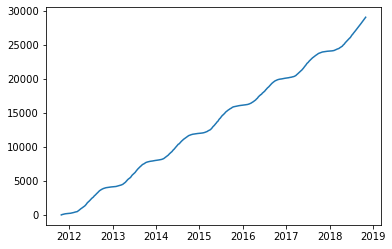

In [21]:
# Append predicted values to the dataset

for i in range(predictions.size):
    dataset = dataset.append(pd.DataFrame({0: predictions[i]}, index=[(dataset.last('1D').index + pd.DateOffset(1))[0]]))

print(dataset.tail(10))
plotter.plot(dataset)